# Отчет по лабораторной работе 1.2

## Исследование эффекта Комптона
Конкс Эрик, Б01-818

### Результат измерения и обработка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy import odr

degrees = [i * 10 for i in range(13)]
N = [584, 571, 552, 465, 435, 360, 323, 290, 259, 228, 219, 191, 175]
pd.DataFrame({'θ, °': degrees, 'N': N}).T

,0,1,2,3,4,5,6,7,8,9,10,11,12
"θ, °",0,10,20,30,40,50,60,70,80,90,100,110,120
N,584,571,552,465,435,360,323,290,259,228,219,191,175


In [2]:
x = 1 - np.cos(np.radians(degrees))
x_error = np.radians(7) * np.sin(np.radians(degrees))
x_error[0] = x_error[1]
y = np.divide(1, N)
y_error = np.divide(2, np.multiply(N, N)) + 0.01 * y
pd.DataFrame({'1-cos(θ)': x, 'Δ(1-cos(θ))': x_error, '1/N': y, 'Δ(1/N)': y_error})

,1-cos(θ),Δ(1-cos(θ)),1/N,Δ(1/N)
0,0.000000,0.021215,0.001712,0.000023
1,0.015192,0.021215,0.001751,0.000024
2,0.060307,0.041786,0.001812,0.000025
3,0.133975,0.061087,0.002151,0.000031
4,0.233956,0.078531,0.002299,0.000034
5,0.357212,0.093590,0.002778,0.000043
6,0.500000,0.105805,0.003096,0.000050
7,0.657980,0.114805,0.003448,0.000058
8,0.826352,0.120317,0.003861,0.000068
9,1.000000,0.122173,0.004386,0.000082


In [3]:
font = {'size'   : 20}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [18, 14]

$$\frac{1}{N(\theta)}-\frac{1}{N(0)}=A(1-cos\theta)$$

$$a=A$$

$$b=\frac{1}{N(0)}$$

In [4]:
f = lambda p, x: p[0] * x + p[1]


quad_model = odr.Model(f)
data = odr.RealData(x, y, sx=x_error, sy=y_error)
modr = odr.ODR(data, quad_model, beta0=[0.002, 0.002])
modr.set_job(fit_type=2)
out = modr.run()
beta_opt = out.beta
beta_err = out.sd_beta
beta_name = ['a', 'b']
print('Fit parameter 1-sigma error y = a * x + b')
print('———————————–—————————————————————————————')
for i in range(len(beta_opt)):
    print(f"{beta_name[i]} = {beta_opt[i]} +- {beta_err[i]}")
    
print(f"chisq = {out.res_var * 11}")
out.pprint()

Fit parameter 1-sigma error y = a * x + b
———————————–—————————————————————————————
a = 0.0026341513864379432 +- 6.005689354652938e-05
b = 0.001715510877064607 +- 2.1301053203740982e-05
chisq = 32.269643397689485
Beta: [0.00263415 0.00171551]
Beta Std Error: [6.00568935e-05 2.13010532e-05]
Beta Covariance: [[ 1.22948787e-09 -2.35945667e-10]
 [-2.35945667e-10  1.54668072e-10]]
Residual Variance: 2.933603945244499
Inverse Condition #: 0.2944420611524752
Reason(s) for Halting:
  Sum of squares convergence


In [5]:
popt, pcov = opt.curve_fit(
    f=lambda x, a, b: a * x + b,       # model function
    xdata=x,   # x data
    ydata=y,   # y data
    p0=(0.002, 0.002),      # initial value of the parameters
    sigma=y_error,   # uncertainties on y,
    # absolute_sigma=True
)
print(popt, np.sqrt(np.diag(pcov)))

[0.00263415 0.00171551] [6.00568955e-05 2.13010535e-05]


In [6]:
from lmfit.models import LinearModel
linear_model = LinearModel()
result = linear_model.fit(y, x=x, weights=1.0/y_error)
result

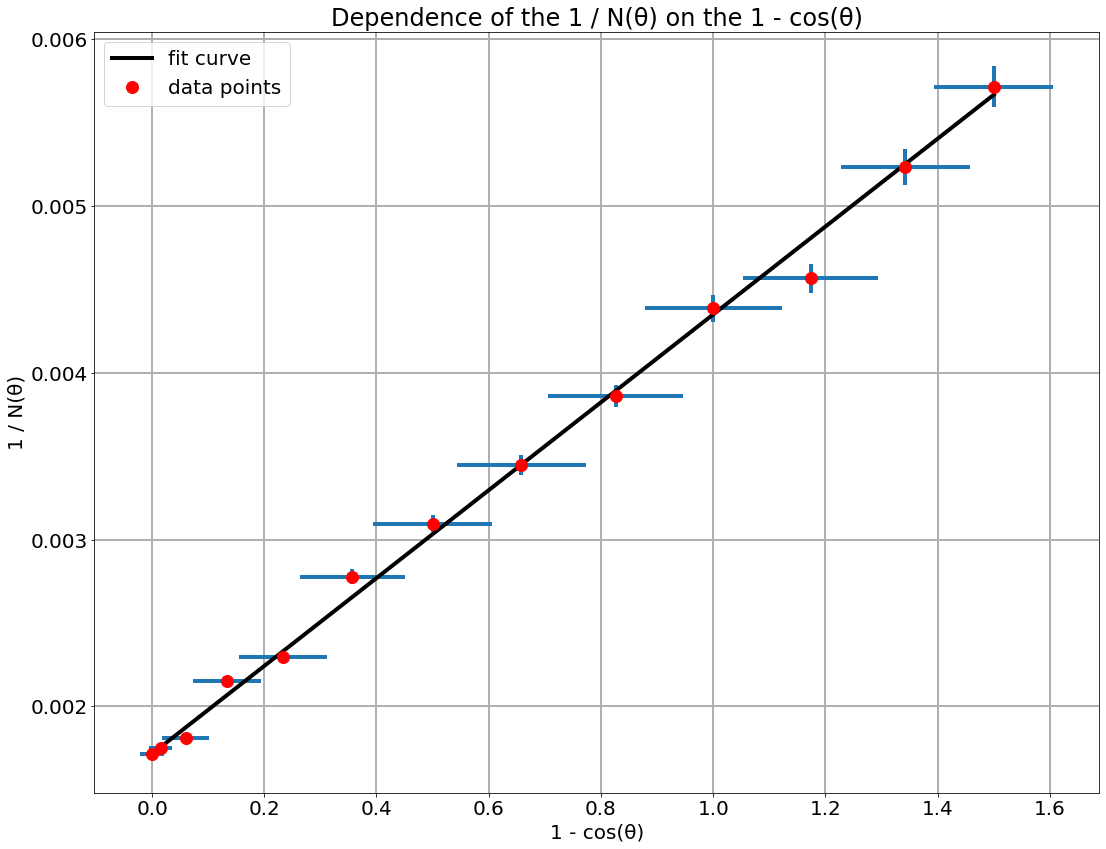

In [7]:
plt.plot(x, f(beta_opt, x), color='black', linewidth=4, label='fit curve')
plt.plot(x, y, 'ro', label='data points', markersize=12)
plt.errorbar(x, y, xerr=x_error, yerr=y_error, fmt="none", linewidth=4)
plt.xlabel('1 - cos(θ)')
plt.ylabel('1 / N(θ)')
plt.grid(linewidth=2)
plt.legend()
plt.title('Dependence of the 1 / N(θ) on the 1 - cos(θ)')
plt.show()

In [8]:
N0 = 1 / beta_opt[1]
N0_err = beta_err[1] * 1 / beta_opt[1] ** 2
N90 = 1 / f(beta_opt, 1-np.cos(np.radians(90)))
N90_err1 = beta_err[0] * 1 / f(beta_opt, 1-np.cos(np.radians(90))) ** 2
N90_err2 = N0_err
N90_err = N90 * (N90_err1 + N90_err2) / (N90 + N0)

$$mc^2=E_\gamma\frac{N(90)}{N(0)-N(90)}$$

In [9]:
Eγ = 662
mc2 = Eγ * N90 / (N0 - N90)
mc2_err = mc2 * (N90_err / N90 + (N0_err + N90_err) / (N0 - N90))
print('Result')
print('———————————–———————————————————————————————————————')
print(f"mc^2 = {mc2} +- {mc2_err} кэВ")
print(f"mc^2 = {int(np.round(mc2))} +- {int(np.round(mc2_err))} кэВ")
print("mc^2 theoretically = 511 кэВ")

Result
———————————–———————————————————————————————————————
mc^2 = 431.1324726679768 +- 17.959217124706463 кэВ
mc^2 = 431 +- 18 кэВ
mc^2 theoretically = 511 кэВ
